In this notebook we compute photon fluxes, i.e. we do not take the detector QE into account.

In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
import simmetis as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sim.__version__

'0.4dev-METIS'

### Number of photons generated in M1 space

##### Compute number of photons in M1 space from basic considerations

In [3]:
area_ELT=np.pi*((38*u.m)**2-(11.1*u.m)**2)/4
eff_wave=11.5*u.micron ## N2 filter
N2_edges=[10.12,13.13]
bandwidth=(np.diff(N2_edges)[0])*u.micron ## N2 filter
solid_angle=(0.01078*u.arcsecond)**2
e_phot=const.h*const.c/eff_wave
r=blackbody_lambda(eff_wave,282*u.K)
emissivity_M1 = 0.23 # total emissivity of ELT according to ESO ICD
emissivity_M1_with_spiders = 0.267 # total emissivity of ELT according to Roy
n_ph_per_s=emissivity_M1_with_spiders*r*bandwidth*area_ELT*solid_angle/e_phot
print("Expected: The number of photons emitted from M1 per second per pixel is {0:.2E}".format(n_ph_per_s.decompose().value))

Expected: The number of photons emitted from M1 per second per pixel is 9.35E+08


##### Now compare this number to what SimMETIS computes

In [4]:
from simmetis.spectral import BlackbodyCurve as sim_bb

In [5]:
## the wave array needs to have > 2 elements, otherwise edge effects 
## make the number of photons a factor of 2 too large
wave_array=np.arange(N2_edges[0],N2_edges[1],0.01)

In [6]:
em=sim_bb(wave_array,282-273.15,pix_res=0.01078,area=area_ELT.value)
em_n_ph=emissivity_M1_with_spiders*em.photons_in_range()
print("SimMETIS: The number of photons emitted from M1 per second per pixel is \
{0:.2E}".format(em_n_ph))

SimMETIS: The number of photons emitted from M1 per second per pixel is 9.31E+08


The two numbers are identical. Yay!

##### Now compare this number to what Roy computed

In [7]:
# to compare to Roy's number the number above needs to be corrected for 
#    - contribution by atmosphere (10%)
#    - contribution by the entrance window (10%)
#    - transmission of N2 filter (36%/77%); divided by transmission of telescope (which is included in the emissivity)
# We thus arrive at
print(n_ph_per_s.decompose())
n_ph_per_s_det = n_ph_per_s*1.1*1.1*0.356/0.77
print("Expected: The number of photons arriving at the detector per second per pixel is {0:.2E}".format(n_ph_per_s_det.decompose().value))

935070647.2573242 1 / s
Expected: The number of photons arriving at the detector per second per pixel is 5.23E+08


This number is essentially compatible with Roy's fluxes document (v0.8, Table 4, N2 filter, median conditions) where 5.5e8 photons are given. The rest of the difference is probably because we only approximated window and atmosphere effects.

### Number of photons on the detector

In [8]:
cmd = sim.UserCommands("metis_image_NQ.config")
cmd["OBS_EXPTIME"]=1
cmd["ATMO_USE_ATMO_BG"] = "yes"
#cmd["ATMO_BG_MAGNITUDE"] = 0.8
cmd["SCOPE_USE_MIRROR_BG"] = "yes"
cmd["SIM_VERBOSE"]="no"
cmd["FPA_QE"]="TC_detector_METIS_NQ_no_losses.dat"

In [9]:
opt = sim.OpticalTrain(cmd)

In [10]:
fpa = sim.Detector(cmd, small_fov=False)

In [56]:
## generate a source with N=0 mag
lam, spec = sim.source.flat_spectrum(0, "TC_filter_N2.dat")
#src = sim.Source(lam=lam, spectra=np.array([spec]), 
#                 ref=[0,0], x=[0,0.07], y=[0,0.07])
src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])
src_chopped = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[1])

In [57]:
opt._gen_thermal_emission() ## this is essentially the same as we calculated above

(953336522.31885302, BlackbodyCurve 
 [ 0.  0.  0. ... 0.  0.  0.])

#### Directly comparing produced and detected number of photons in SimMETIS

In [58]:
opt._gen_thermal_emission()[1].photons_in_range()
# this is more or less consistent with the line before

954741966.04670477

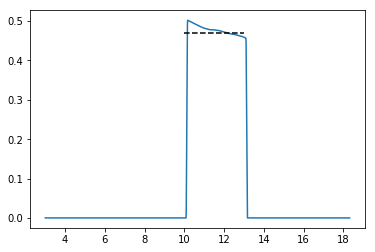

In [59]:
plt.plot(opt.tc_mirror.lam,opt.tc_mirror.val)
plt.plot([10,13],[0.47,0.47],'k--')
# this is the total transmission of METIS without detector QE in this filter (and the assumed average transmission)

In [60]:
opt._gen_all_tc()
opt.n_ph_mirror
# this is the number of background photons we get in the final produced image
# this number is ~2% lower than the two numbers above multiplied with each other (i.e. essentially identical)

443571928.26534402

#### Generate the transmission curves ourselves

In [61]:
TC_ELT=sim.spectral.TransmissionCurve("TC_mirror_total_emissivity.dat")

In [62]:
TC_window=sim.spectral.TransmissionCurve("TC_window_METIS.dat")

In [63]:
TC_dichroic_CFO=sim.spectral.TransmissionCurve("TC_dichroic_CFO.dat")

In [64]:
# TC pupil is 1

In [65]:
TC_CFO_mirrors=sim.spectral.TransmissionCurve("TC_mirror_aluminium.dat")

In [66]:
TC_CFO=TC_CFO_mirrors**19

In [67]:
TC_dichroic_IMG=sim.spectral.TransmissionCurve("TC_dichroic_IMG.dat")

In [68]:
TC_N2=sim.spectral.TransmissionCurve("TC_filter_N2.dat")

In [69]:
#QE_AQUARIUS=sim.spectral.TransmissionCurve("TC_detector_METIS_NQ.dat")
QE_AQUARIUS=sim.spectral.TransmissionCurve("TC_detector_METIS_NQ_no_losses.dat")

In [70]:
TC_total=TC_ELT*TC_window*TC_dichroic_CFO*TC_CFO*TC_dichroic_IMG*TC_N2*QE_AQUARIUS

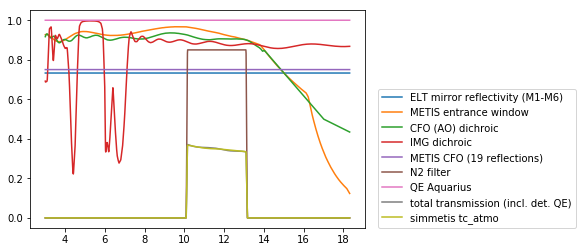

In [71]:
plt.plot(opt.tc_mirror.lam,TC_ELT,label="ELT mirror reflectivity (M1-M6)")
plt.plot(opt.tc_mirror.lam,TC_window,label="METIS entrance window")
plt.plot(opt.tc_mirror.lam,TC_dichroic_CFO,label="CFO (AO) dichroic")
plt.plot(opt.tc_mirror.lam,TC_dichroic_IMG,label="IMG dichroic")
plt.plot(opt.tc_mirror.lam,TC_CFO,label="METIS CFO (19 reflections)")
plt.plot(opt.tc_mirror.lam,TC_N2,label="N2 filter")
plt.plot(opt.tc_mirror.lam,QE_AQUARIUS,label="QE Aquarius")
plt.plot(opt.tc_mirror.lam,TC_total,label="total transmission (incl. det. QE)")
#plt.plot(opt.tc_mirror.lam,opt.tc_mirror,label="simmetis tc_mirror")
plt.plot(opt.tc_mirror.lam,opt.tc_atmo,label="simmetis tc_atmo")
plt.legend(loc=(1.04, 0))
plt.savefig("METIS_transmission_curves.png")

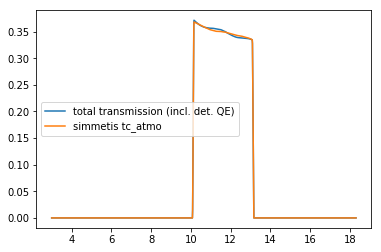

In [72]:
plt.plot(opt.tc_atmo.lam,TC_total,label="total transmission (incl. det. QE)")
plt.plot(opt.tc_atmo.lam,opt.tc_atmo,label="simmetis tc_atmo")
plt.legend(loc='best')

#### Compute number of background photons in SimMETIS simulated image

In [73]:
src.apply_optical_train(opt, fpa)
exptime=1
photonflux = fpa.chips[0].array.T
clean_image = photonflux * exptime ## noise free image before applying Poisson noise

hdu = fpa.read_out(OBS_EXPTIME=1)
src_chopped.apply_optical_train(opt,fpa)
hdu_chopped = fpa.read_out(OBS_EXPTIME=1)

Generating image for chip 1
Reading out chip 1 using superfast
5.25709320468e+14 501319002.653 1312762380.75 501319002.653
5.25709e+14 5.01211e+08 1.31278e+09 5.0132e+08
Generating image for chip 1
Reading out chip 1 using superfast
5.25709320468e+14 501319002.653 1312762380.75 501319002.653
5.25709e+14 5.01212e+08 1.31276e+09 5.0132e+08


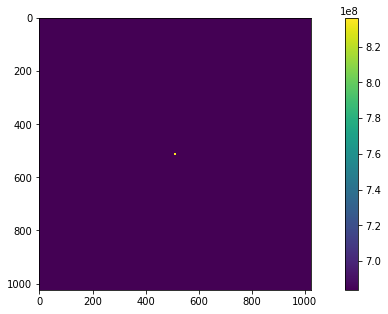

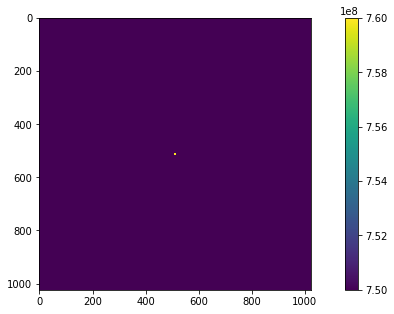

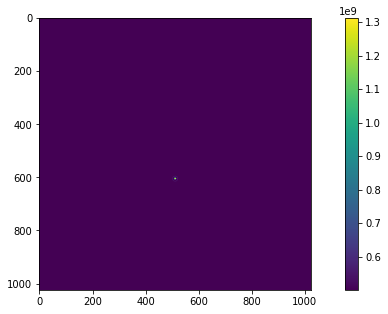

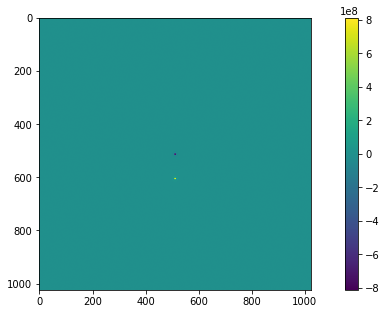

In [74]:
##
## chop A frame
plt.figure(figsize=(12,5))
plt.imshow(hdu[0].data, interpolation="none", vmin=7.6e8,vmax=7.6e8)
plt.colorbar()
##
## chop A frame without noise
plt.figure(figsize=(12,5))
plt.imshow(clean_image, interpolation="none", vmin=7.5e8,vmax=7.6e8)
plt.colorbar()
##
## chop B frame
plt.figure(figsize=(12,5))
plt.imshow(hdu_chopped[0].data, interpolation="none")
plt.colorbar()
##
## chop difference A-B frame
plt.figure(figsize=(12,5))
plt.imshow(hdu_chopped[0].data-hdu[0].data, interpolation="none")
plt.colorbar()

In [75]:
bgphotons_per_pix=np.median(hdu[0].data)
bgphotons_per_pix*=1.1 ## takes into account bg photons from entrance window, not included in the simulation so far
print("The number of bg counts per second per pix is {0:.2E}".format(bgphotons_per_pix))
## Note that this is identical with bg photons if detector QE is 1 (as in TC_detector_METIS_NQ_no_losses.dat)

The number of bg counts per second per pix is 5.51E+08


This number can be compared with 5.5e8 from Roy's doc (N2/median, Table 4, version 0.8).

## ELFN

In [76]:
from  scipy.interpolate import interp1d
def ELFN_penalty(photonflux):
    x=[0, 2e8, 8e8,10e8,25e8] # [ph/s/pix]
    y=[1,1.37,3.38,3.64,4.65] # ELFN noise penalty factor from Roy
    penalty_interp=interp1d(x,y)
    penalty=penalty_interp(photonflux)[()]
    return(penalty)

In [77]:
noise = hdu[0].data - clean_image
elfn_image = clean_image + ELFN_penalty(photonflux)*noise
print(np.median(elfn_image[200:400,200:400]))
print(np.std(elfn_image[200:400,200:400]))

501319854.014
53359.5028588


## Source photons

In [78]:
source_bgsubtracted = np.sum(clean_image-np.median(clean_image))
print("Bg-subtracted source photons (per s): {0:.2E}".format(source_bgsubtracted))

Bg-subtracted source photons (per s): 3.82E+10


In [79]:
# this matches sufficiently well with the expected flux from Roy which is 3.95e10

### Compare to the number of photons to expect

In [ ]:
# check sim.source.photons_to_mag

In [80]:
# A0V star of 0 mag corresponds to 30.072 Jy in N2 according to Roy
from astropy import units as u
from astropy import constants as c
F = 30.072 * u.Jy
lam1=10.12*u.micron
lam2=13.13*u.micron
nu1 = c.c/lam1
nu2 = c.c/lam2
bandwidth_nu = - (nu2-nu1)

In [81]:
e_ph = c.h*(0.5*(nu2+nu1))
N_ph = (F * 1*u.s * area_ELT * bandwidth_nu / e_ph).decompose()
N_ph # without transmission losses

<Quantity 121899936112.71233>

In [82]:
# including transmission losses -- it matches rougly with the numbers above (given)
## 0.36: total system transmission ELT+METIS of N2 filter / without atmospheric losses
## 0.6: detector QE (not included here for the time being)
N_ph * 0.36

<Quantity 43883977000.57644>

### Other tests

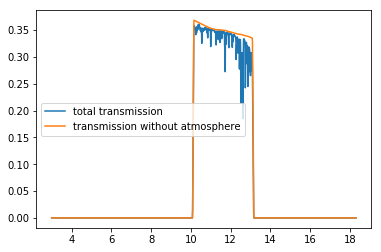

In [83]:
# The transmission curve used (tc_source includes atmosphere; tc_atmo, despite its name, doesn't)
plt.plot(opt.tc_source.lam,opt.tc_source,label="total transmission")
plt.plot(opt.tc_atmo.lam,opt.tc_atmo, label="transmission without atmosphere")
plt.legend()

(10, 13)

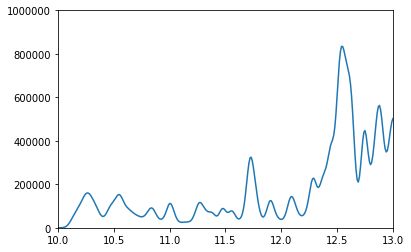

In [84]:
# atmosphere
from scipy.ndimage.filters import gaussian_filter
plt.plot(opt.ph_atmo.lam,gaussian_filter(opt.ph_atmo,sigma=3))
plt.ylim([0,1e6])
plt.xlim([10,13])